# Object detection - Pascal VOC dataset

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
torch.cuda.set_device(0)

## Dataset: Pascal VOC

In [4]:
PATH = Path('data/pascal_voc//')

In [5]:
list(PATH.iterdir())

[PosixPath('data/pascal_voc/VOC2007'),
 PosixPath('data/pascal_voc/pascal_test2007.json'),
 PosixPath('data/pascal_voc/pascal_train2012.json'),
 PosixPath('data/pascal_voc/pascal_val2012.json'),
 PosixPath('data/pascal_voc/pascal_train2007.json'),
 PosixPath('data/pascal_voc/pascal_val2007.json')]

In [6]:
trn_json = json.load((PATH/'pascal_train2007.json').open())

In [7]:
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [8]:
IMAGES, ANNOTATIONS, CATEGORIES = 'images', 'annotations', 'categories'  # so i can use tab to autocomplete

**Images:**

In [9]:
trn_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}]

**Bounding boxes:**

`bbox:` column and row of top left corner of bounding box, height and with of bounding box

`image_id:` to which image the bounding box belongs

`category_id:` category of the object in the bounding box

`iscrowd:` are there several objects of this category in the image?


In [10]:
trn_json[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

**Categories:**

In [11]:
trn_json[CATEGORIES][:5]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'}]

Let's put the categories, filenames and image ids in python dictionaries for convenience:

In [12]:
FN, ID, IMG_ID, CAT_ID, BBOX, NAME = 'file_name', 'id', 'image_id', 'category_id', 'bbox', 'name'

In [13]:
cats = dict((i[ID], i[NAME]) for i in trn_json[CATEGORIES])
trn_fns = dict((i[ID], i[FN]) for i in trn_json[IMAGES])
trn_ids = [i[ID] for i in trn_json[IMAGES]]

In [14]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal_voc/VOC2007/ImageSets'),
 PosixPath('data/pascal_voc/VOC2007/JPEGImages'),
 PosixPath('data/pascal_voc/VOC2007/SegmentationClass'),
 PosixPath('data/pascal_voc/VOC2007/SegmentationObject'),
 PosixPath('data/pascal_voc/VOC2007/Annotations')]

In [15]:
JPEGS = 'VOC2007/JPEGImages'

In [16]:
IMPATH = PATH/JPEGS

In [17]:
list(IMPATH.iterdir())[:2]

[PosixPath('data/pascal_voc/VOC2007/JPEGImages/003034.jpg'),
 PosixPath('data/pascal_voc/VOC2007/JPEGImages/007859.jpg')]

**Let's create a dictionary that maps image ids to bounding boxes and classes:**

* `defaultdict` uses a default key for new entries
* switch x and y to be consistent with numpy
* convert top-left corner coordinates + height + width to top-left and bottom-right coordinates of the bounding boxes

In [18]:
trn_json[IMAGES][0][FN], trn_json[IMAGES][0][ID]

('000012.jpg', 12)

In [19]:
trn_json[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [20]:
def convert_bb_to_np(bb):
    return np.array([bb[1], bb[0], bb[1] + bb[3] - 1, bb[0] + bb[2] - 1])

def convert_bb_to_VOC(bb):
    return np.array([bb[1], bb[0], bb[3]-bb[1] + 1, bb[2]-bb[0] + 1])

In [21]:
# Let's quickly test it:
convert_bb_to_VOC(convert_bb_to_np([155, 96, 196, 174]))

array([155,  96, 196, 174])

In [22]:
trn_annotations = collections.defaultdict(lambda: [])

for o in trn_json[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = convert_bb_to_np(bb)
        trn_annotations[o[IMG_ID]].append((bb, o[CAT_ID]))

In [23]:
len(trn_annotations)

2501

**Let's check if everything went according to plan:**

In [24]:
trn_json[IMAGES][0]

{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}

In [25]:
trn_json[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [26]:
trn_annotations[12]

[(array([ 96, 155, 269, 350]), 7)]

In [27]:
cats[7]

'car'

## Let's look at some images and their bounding boxes

In [28]:
# using the new matplotlib API
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

Nice convenience function that creates white text/outlines with black backround or vice versa for better visibility:

In [29]:
def draw_outline(matplt_plot_obj, lw):
    matplt_plot_obj.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [30]:
def draw_rectangle(ax, bb):
    patch = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [31]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [32]:
ex_img = trn_json[IMAGES][0]
im = open_image(IMPATH/ex_img[FN])
annos = trn_annotations[ex_img[ID]][0]

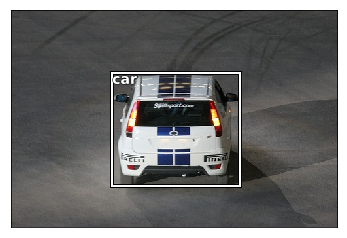

In [33]:
ax = show_img(im)
bb = convert_bb_to_VOC(annos[0])
draw_rectangle(ax, bb)
draw_text(ax, bb[:2], cats[annos[1]])

**However, what we want is a function that is only passed an index of a training input and that prints the respective  image and bounding boxes.**

In [34]:
def draw_image(im, annot):
    ax = show_img(im, figsize=(16,8))
    for bbox, cat in annot:
        bb = convert_bb_to_VOC(bbox)
        draw_rectangle(ax, bb)
        draw_text(ax, bb[:2], cats[cat], sz=16)

In [35]:
def draw_idx(i):
    im_annot = trn_annotations[i]
    im = open_image(IMPATH/trn_fns[i])
    print(im.shape)
    draw_image(im, im_annot)

(366, 500, 3)


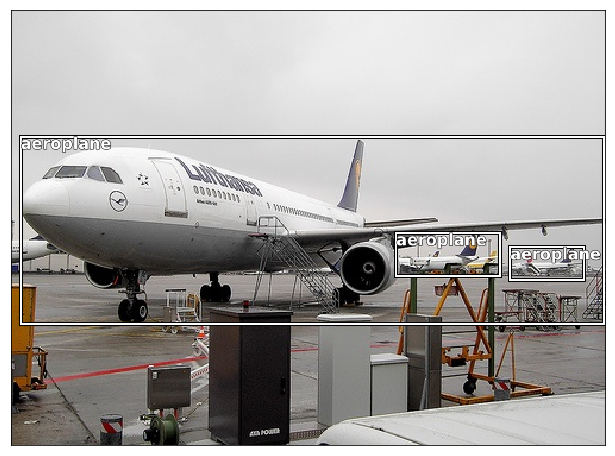

In [36]:
draw_idx(33)

## Step 1: Build a classifier that detects the *largest* object

First thing we need to do is convert the dict `trn_annotations` to a dict that only contains the largest bounding box:

In [37]:
# x[0] is the bounding box (x[1] would be the category)
# dot product calculates the area of the bounding box:
# x[0][-2:] - x[0][:2] is bottom right corner coords 
# minus top left corner coords. Result is np.array with
# width and height

def get_lrgst_bb(bb):
    if not bb:
        raise Exception()
    bb = sorted(bb, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return bb[0]

In [44]:
nones = [i for i, bb in trn_annotations.items() if len(bb) == 0]

In [45]:
for n in nones:
    trn_annotations.pop(n)

In [46]:
trn_lrgst_annot = {key:get_lrgst_bb(item) for key, item in trn_annotations.items()}

**This dictionary contains the single largest bounding box (+ category) for every picture).**

In [53]:
bb, cat = trn_lrgst_annot[23]

In [54]:
bb = convert_bb_to_VOC(bb)

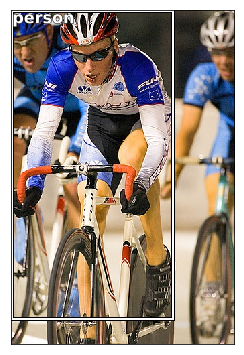

In [60]:
ax = show_img(open_image(IMPATH/trn_fns[23]),figsize=(4,8))
draw_rectangle(ax, bb)
draw_text(ax, bb[:2], cats[cat], sz=16)

**fast.ai already has the very handy `ImageClassifierData.from_csv`. Let's create a csv so that we can use it.**

In [61]:
(PATH/'tmp').mkdir(exist_ok=True)

In [62]:
CSV = PATH/'tmp/lrg.csv'

In [68]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'cat': [cats[trn_lrgst_annot[o][1]] for o in trn_ids]}, columns=['fn', 'cat'])

In [74]:
df.head(1)

,fn,cat
0,000012.jpg,car


In [75]:
trn_annotations[12]

[(array([ 96, 155, 269, 350]), 7)]

In [76]:
cats[7]

'car'

**Looks good**

In [77]:
df.to_csv(CSV, index=False)